In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

In [ ]:
cd /content/drive/MyDrive/comma_ai_dev/Probono-AI-Model

/content/drive/MyDrive/comma_ai_dev/Probono-AI-Model


In [ ]:
df = pd.read_csv('pildong_data.csv', index_col=0, parse_dates=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
train = df.iloc[:-720]  #test 데이터셋:8040
test = df.iloc[-720:] #train 데이터셋: 720 (한달치 data)

In [ ]:
 #데이터 scaling
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
pd.DataFrame(scaled_train, index = train.index, columns=train.columns)

,population
Datetime,
2022-08-01 00:00:00,0.073177
2022-08-01 01:00:00,0.069470
2022-08-01 02:00:00,0.071029
2022-08-01 03:00:00,0.072353
2022-08-01 04:00:00,0.078535
...,...
2023-07-01 19:00:00,0.199274
2023-07-01 20:00:00,0.164376
2023-07-01 21:00:00,0.128544


In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
scaled_train = scaled_train.reshape(-1)
scaled_test = scaled_test.reshape(-1)
print(scaled_train.shape)
print(scaled_test.shape)

(8040,)
(720,)


In [ ]:
n_steps = 168 #일주일치 데이터
n_features = 1  #단변량 데이터

x_train, y_train = split_sequence(scaled_train, n_steps) #x_train = (7872,168), y_train = (7872,1)
x_test, y_test = split_sequence(scaled_test, n_steps) #x_test = (552,168), y_test = (552,1)

In [ ]:
pd.DataFrame(x_train.T,
             index = [f'day{x+1}' for x in range(x_train.shape[1])],
             columns = [f'input_{x+1}' for x in range(x_train.shape[0])])

,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,...,input_7863,input_7864,input_7865,input_7866,input_7867,input_7868,input_7869,input_7870,input_7871,input_7872
day1,0.073177,0.069470,0.071029,0.072353,0.078535,0.089083,0.112150,0.171086,0.292928,0.401148,...,0.253704,0.262655,0.253965,0.246034,0.214218,0.190030,0.158570,0.112895,0.081840,0.083782
day2,0.069470,0.071029,0.072353,0.078535,0.089083,0.112150,0.171086,0.292928,0.401148,0.435848,...,0.262655,0.253965,0.246034,0.214218,0.190030,0.158570,0.112895,0.081840,0.083782,0.070181
day3,0.071029,0.072353,0.078535,0.089083,0.112150,0.171086,0.292928,0.401148,0.435848,0.502107,...,0.253965,0.246034,0.214218,0.190030,0.158570,0.112895,0.081840,0.083782,0.070181,0.066404
day4,0.072353,0.078535,0.089083,0.112150,0.171086,0.292928,0.401148,0.435848,0.502107,0.503906,...,0.246034,0.214218,0.190030,0.158570,0.112895,0.081840,0.083782,0.070181,0.066404,0.062865
day5,0.078535,0.089083,0.112150,0.171086,0.292928,0.401148,0.435848,0.502107,0.503906,0.513255,...,0.214218,0.190030,0.158570,0.112895,0.081840,0.083782,0.070181,0.066404,0.062865,0.064502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
day164,0.106392,0.097866,0.080464,0.068970,0.056055,0.053830,0.058814,0.057735,0.057804,0.064517,...,0.153780,0.177403,0.198788,0.216924,0.222706,0.235469,0.216397,0.220010,0.207665,0.214016
day165,0.097866,0.080464,0.068970,0.056055,0.053830,0.058814,0.057735,0.057804,0.064517,0.071256,...,0.177403,0.198788,0.216924,0.222706,0.235469,0.216397,0.220010,0.207665,0.214016,0.199274
day166,0.080464,0.068970,0.056055,0.053830,0.058814,0.057735,0.057804,0.064517,0.071256,0.101462,...,0.198788,0.216924,0.222706,0.235469,0.216397,0.220010,0.207665,0.214016,0.199274,0.164376
day167,0.068970,0.056055,0.053830,0.058814,0.057735,0.057804,0.064517,0.071256,0.101462,0.168890,...,0.216924,0.222706,0.235469,0.216397,0.220010,0.207665,0.214016,0.199274,0.164376,0.128544


In [ ]:
pd.DataFrame(y_train.T,
             index = [f'output_{x+1}' for x in range(y_train.shape[0])],
             columns = [f'day1'])

,day1
output_1,0.053830
output_2,0.058814
output_3,0.057735
output_4,0.057804
output_5,0.064517
...,...
output_7868,0.199274
output_7869,0.164376
output_7870,0.128544
output_7871,0.093613


In [ ]:
model = Sequential()

model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps,n_features))) #first layer
model.add(Dropout(0.5))

model.add(LSTM(units = 64)) #second layer
model.add(Dropout(0.5))

model.add(Dense(1)) #output layer

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 128)          66560     
                                                                 
 dropout (Dropout)           (None, 168, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
#모델의 val_loss가 10epoch 동안 동일하면 학습을 중단

history = model.fit(x_train, y_train, epochs=50, callbacks=[early_stopping])

Epoch 1/50
246/246 [==============================] - 30s 89ms/step - loss: 0.0217 - mae: 0.1017
Epoch 2/50
246/246 [==============================] - 22s 88ms/step - loss: 0.0056 - mae: 0.0531
Epoch 3/50
246/246 [==============================] - 22s 89ms/step - loss: 0.0045 - mae: 0.0474
Epoch 4/50
246/246 [==============================] - 21s 87ms/step - loss: 0.0037 - mae: 0.0420
Epoch 5/50
246/246 [==============================] - 21s 87ms/step - loss: 0.0033 - mae: 0.0397
Epoch 6/50
246/246 [==============================] - 21s 87ms/step - loss: 0.0029 - mae: 0.0372
Epoch 7/50
246/246 [==============================] - 22s 88ms/step - loss: 0.0028 - mae: 0.0365
Epoch 8/50
246/246 [==============================] - 22s 89ms/step - loss: 0.0026 - mae: 0.0351
Epoch 9/50
246/246 [==============================] - 21s 86ms/step - loss: 0.0024 - mae: 0.0340
Epoch 10/50
246/246 [==============================] - 22s 88ms/step - loss: 0.0022 - mae: 0.0324
Epoch 11/50
246/246 [========

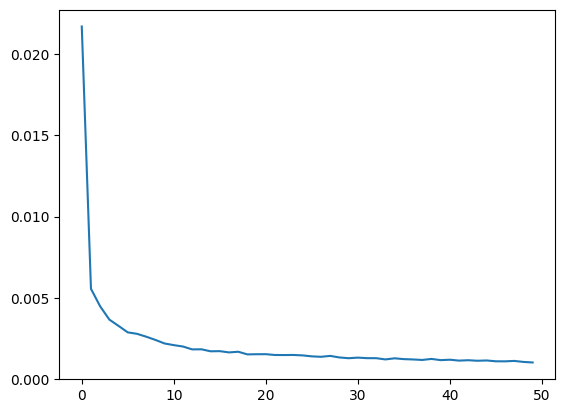

In [ ]:
import matplotlib.pyplot as plt
myloss = model.history.history['loss']
plt.plot(range(len(myloss)), model.history.history['loss'])

In [ ]:
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# tratrainPredict = scaler.inverse_transform(trainPredict)
#train값과 test값 예측
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

# 역정규화 과정
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

# rmse 계산
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

18/18 [==============================] - 0s 23ms/step
Train Score: 490.86 RMSE
Test Score: 409.31 RMSE


<Axes: xlabel='Datetime'>

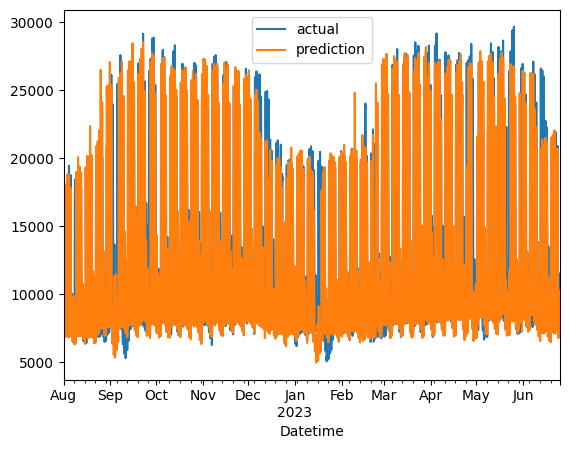

In [ ]:
val_train  = pd.DataFrame() #예측값 검증을 위한 df 생성

trainPredict = pd.DataFrame(trainPredict)
trainPredict.index = train[:len(trainPredict)].index #실제 test 범위에 해당하는 index 매칭

val_train['actual'] = train[:len(trainPredict)] #실제 값 할당
val_train['prediction'] = trainPredict #예측한 값 할당

val_train.plot()

<Axes: xlabel='Datetime'>

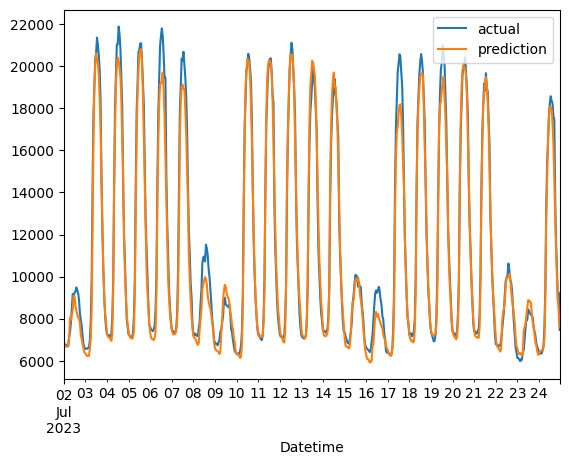

In [ ]:
val_test = pd.DataFrame() #예측값 검증을 위한 df 생성

testPredict = pd.DataFrame(testPredict)
testPredict.index = test[:len(testPredict)].index #실제 test 범위에 해당하는 index 매칭

val_test['actual'] = test[:len(testPredict)] #실제 값 할당
val_test['prediction'] = testPredict #예측한 값 할당

val_test.plot()

In [ ]:
from keras.models import load_model
model.save("population_predict.h5")